<h6><center>Big Data Algorithms Techniques & Platforms</center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center>Assignment 1: Introduction to MapReduce</center>
<hr style=" border:none; height:3px;">
</h1>


# <strong> Important </strong>

For this assignment, as you did in the first lab, do not use the native fuctions <code>map()</code> and <code>reduce()</code> of Python.


<hr>



## Flights and Airports Data

For this assignment you are going to analyze a dataset that will include flight data.

The dataset comes from <a href="https://www.kaggle.com/flashgordon/usa-airport-dataset">Kaggle</a> and is presented here as an extract called <code>extract_flights.csv</code>

The dataset is in a <code>.csv</code> file. Each line of the file represents a different flight. The data collected contain:


<code>Origin_airport</code>: Three letter airport code of the origin airport </br>
<code>Destination_airport</code>: Three letter airport code of the destination airport</br>
<code>Origin_city</code>: Origin city name</br>
<code>Destination_city</code>: Destination city name</br>
<code>Passengers</code>: Number of passengers transported from origin to destination</br>
<code>Seats</code>: Number of seats available on flights from origin to destination</br>
<code>Flights</code>: Number of flights between origin and destination (multiple records for one month, many with flights > 1)</br>
<code>Distance</code>: Distance (to nearest mile) flown between origin and destination</br>
<code>Fly_date</code>: The date (yyyymm) of flight</br>
<code>Origin_population</code>: Origin city's population as reported by US Census</br>
<code>Destination_population</code>: Destination city's population as reported by US Census</br>


Two files are available in the folder:

<ul>
  <li> <code> small_file.csv</code> </li>
  <li> <code> medium_file.csv</code> </li>
</ul>

For more complex analysis/statistics you can also download the original file available on kaggle.



Link to colab: https://colab.research.google.com/drive/1zwmACYwl4GX1T80blvBHcHY1bWswYXNm

### Helper function ... just in case

Here is a function that you can modify, reuse, not-use for giving you an idea about how to read a <code>.csv</code> file and remove the header.

In [1]:
# Here a simple function that reads a .csv file, removes the header,
# and writes the output on a .txt file having the same name of the input file + the keyword "no_header"
# input: a csv file
def remove_header(filename) :
  with open(filename + ".csv",'r') as f:
    with open(filename + "no_header.txt",'w') as f1:
        next(f) # skip header line
        for line in f:
            f1.write(line)
  return f1

gg = remove_header('data/small_file')
print("file correctly saved")


file correctly saved


In [2]:
import csv
import numpy as np
from collections import defaultdict 
import math
import warnings 

#Ignore zero divide warnings 
warnings.filterwarnings('ignore')

            
#DataLoader class, that functions the same as an InputReader
class DataLoader:
    int_types = ['Passengers','Seats','Flights','Distance','Origin_population',
                    'Destination_population']
    float_types = ['Org_airport_lat','Org_airport_long',
                    'Dest_airport_lat','Dest_airport_long']
    
    def __init__(self, file_path):
        self.file_path = file_path
        
    def loaddata(self, filename):
        with open(filename + ".csv", "r") as csv_file:
            reader = csv.reader(csv_file)
            for row in reader:
                yield np.array(row)
                     
    def load_dict(self):
        table = defaultdict(list)
        columns = [row for row in self.loaddata(self.file_path)]
        for column in columns[0]: 
            table[column]
        for column in columns[1:]:
            for key, element in zip(table.keys(),column):
                if element != 'NA':
                    if key in self.int_types:
                        table[key].append(int(element))
                    elif key in self.float_types:
                        table[key].append(float(element))
                    else:
                        table[key].append(element)
                else:
                    table[key].append(math.nan)
        
        
        return table

Once the data has been loaded into a readable format, we need to treat it like streaming data that keeps incoming at rapid rates, ensuring that for a certain data size, it's chunked appropriately into the right nodes and then parallelly processed under the MapReduce protocol

In [188]:
#Loading in the small and medium size data
dl_small = DataLoader("data/small_file")
dl_medium = DataLoader("data/medium_file")
small_data = dl_small.load_dict()
medium_data = dl_medium.load_dict()

### <strong> Exercise 1 - Almost-empty flights</strong> 
#### <strong> 4 points </strong>
Describe and define a MapReduce procedure that gives as output the number of flights that departed with 10% of capacity maximum (i.e. empty, 1%, 6%, etc.) . 

The output can be of any form you like. 

You can use any data structure you want to support your implementation.




In [189]:
#Provide here few comment lines that describe your map function

'''
The mapper procedure will work under a simple framework: 

1. The mapper will take two arguments: The Passenger count in each flight and the total seats count 
2. The observed capacity percentage (call it 'a') will be the percentage of the count of passengers (x) 
over the total seats in the flight (y); a = x/y
3. Map each value to a key-value pair tuple in order to keep track of them. 
'''

def map_e_flights(passenger_count,total_seats_count,total_flights):
    #Calculates the percentage ratio and rounds it off to 3 decimal places .
    pct_occupancy = np.true_divide(np.array(passenger_count),np.array(total_seats_count))
    mapped_occupancies = [("10% or less",flights) if pct <= 0.1 else ("10% or more",flights) 
                          for pct,flights in zip(pct_occupancy,total_flights)]
    return mapped_occupancies

# #Provide here few comment lines that describe your shuffle function
'''
The shuffler will work under the following framework: 

1. Track the total values for each key that is available and shuffle them to the same group 
2. Store these shuffled key-value pairs under two different arrays 
'''
def shuffle_e_flights(mapped_occupancies):
    #Stores the values in a defaultdict, with a list as a factory default 
    shuffle_dict = defaultdict(list)
    for pair in mapped_occupancies:
        shuffle_dict[pair[0]].append(pair[1])
    return shuffle_dict
    
#Provide here few comment lines that describe your reduce function

'''
The reducer will count the frequency of values appearing for each key and then 
output the frequency for each key
'''
def reduce_e_flights(shuffle_dict):
    #Returns the sum of values appearing for each key in the shuffler
    total_sum = [(key, sum(value)) for key,value in shuffle_dict.items()]
    print(total_sum)

In [190]:
reduce_e_flights(shuffle_e_flights(map_e_flights(small_data['Passengers'],small_data['Seats'],small_data['Flights'])))
reduce_e_flights(shuffle_e_flights(map_e_flights(medium_data['Passengers'],medium_data['Seats'],medium_data['Flights'])))

[('10% or more', 143472), ('10% or less', 1267)]
[('10% or more', 3121046), ('10% or less', 13812)]


Look at your implementation and think about your program. Is there any option to add a `combine` operation?  If yes describe your new approach and provide an improved version of your code.

Describe in detail your procedure before the code (in the comment lines).

In [6]:
#Provide here a detailed comment that describes your new function

### <strong> Exercise 2 - Top five destination airports </strong>
### <strong> 4 points </strong>

Provide now a function that lists the top five destination <strong>airports</strong>: the ones that have the highest number of incoming flights. Implement an algorithm that uses the MapReduce procedure.



In [7]:
#Provide here few comment lines that describe your map function

'''
The mapper function works with the following idea: 

Each destination airport is a key of its own, which can be mapped to the total number of flights which 
arrived to the destination airport. Hence the mapper will produce a key-value pair where the keys are the 
destination airports and the value is the number of flights that arrived there. 
'''

def map_top_flights(destination_airports, flights):
    mapped_airports = [(airport,flight) for airport,flight in zip(destination_airports,flights)]
    return mapped_airports

#Provide here few comment lines that describe your shuffle function

'''
The shuffler will shuffle all the flights for each airport under matching Destination airports, 
where each group is defined by the key, the key being the Destination airport name. 
'''

def shuffle_top_flights(mapped_airports):
    shuffle_dict = defaultdict(list)
    for pair in mapped_airports:
        shuffle_dict[pair[0]].append(pair[1])
    return shuffle_dict


#Provide here few comment lines that describe your reduce function

'''
The reducer will out the total number of flights for each destination airport by summing all the incoming 
flights that arrived at the destination airport. 
'''

def reduce_top_flights(shuffle_dict):
    total_sum = sorted([(key, sum(value)) for key, value in shuffle_dict.items()], key=lambda x: x[1],
                      reverse=True)
    #Print the top 5 destination airports 
    print(total_sum[:5])

In [8]:
#Small data
reduce_top_flights(shuffle_top_flights(map_top_flights(small_data['Destination_airport'], small_data['Flights'])))
#Medium data
reduce_top_flights(shuffle_top_flights(map_top_flights(medium_data['Destination_airport'], medium_data['Flights'])))

[('RDM', 108593), ('EKO', 25742), ('ERI', 7101), ('WDG', 3295), ('END', 7)]
[('MIA', 1486648), ('RNO', 551046), ('ITO', 201861), ('CAK', 161237), ('FNT', 127985)]


### <strong> Exercise 3 - Top 5 destination cities </strong>
#### <strong>  2 points </strong>

Try to reuse the code you run before and define a function that lists the top five destination <strong>cities</strong>: the ones that have the highest number of incoming flights. Implement an algorithm that uses the MapReduce procedure.


In [9]:
#Provide here few comment lines that describe your map function

'''
The mapper function will map the destination cities and the number of flights that took off from there as a 
key-value pair.
'''

def map_top_cities(destination_cities, flights):
    mapped_cities = [(city,flight) for city,flight in zip(destination_cities,flights)]
    return mapped_cities

#Provide here few comment lines that describe your shuffle function

'''
The shuffler will shuffle all the flights for each airport under matching destination city, 
where each group is defined by the key, the key being the destination city name. 
'''

def shuffle_top_cities(mapped_cities):
    shuffle_dict = defaultdict(list)
    for pair in mapped_cities:
        shuffle_dict[pair[0]].append(pair[1])
    return shuffle_dict

# #Provide here few comment lines that describe your reduce function

'''
The reducer will perform the same reduce operation as the "reduce_top_flights" reducer, outputting the sum 
of the total flights that arrived to the destination city.
'''

def reduce_top_cities(shuffle_dict):
    total_sum = sorted([(key, sum(value)) for key, value in shuffle_dict.items()], key=lambda x: x[1],
                      reverse=True)
    #Print the top 5 destination cities
    print(total_sum[:5])

In [10]:
reduce_top_cities(shuffle_top_cities(map_top_cities(small_data['Destination_city'], small_data['Flights'])))
reduce_top_cities(shuffle_top_cities(map_top_cities(medium_data['Destination_city'], medium_data['Flights'])))

[('Bend, OR', 108593), ('Elko, NV', 25742), ('Erie, PA', 7101), ('Enid, OK', 3302), ('Ames, IA', 1)]
[('Miami, FL', 1487169), ('Reno, NV', 551046), ('Hilo, HI', 201861), ('Akron, OH', 161237), ('Flint, MI', 127985)]


## Statistics on flights

<p align="justify">
<font size="3">
Now we want to run some more complex analysis on the flights. 
</font>
</p>





### <strong> Exercise 4 - Top five connections by month</strong>
#### <strong> 4 points </strong>

Try to reuse the code you run before and define now a function that lists the top five connections by each month: the top five pairs of cities that have the most number of connections (the function takes into account the flights from A to B and from B to A by month/year). Implement an algorithm that uses the MapReduce procedure.

In [11]:
#Provide here few comment lines that describe your map function

'''
The mapper function works with a different approach here: 

Here, the key itself is a tuple which tracks three different things: 
1. The dates of the flight
2. The origin airport of these flights
3. The destination airport of these flights.

The reason we track these three things inside a tuple is because we want to count the total 
number of flights that came both ways; from Origin -> Destination and from Destination -> Origin.

The value is the number of flights that flew from the origin to the destination for the given date.
'''
def map_top_connections(dates,origin,destination,flights):
    #Track the unique dates  
    mapped_top_connections = [((date,origin,destination),flight) for date,origin,destination,flight 
                             in zip(dates,origin,destination,flights)]
    return mapped_top_connections

#Provide here few comment lines that describe your shuffle function

'''
The shuffler function will shuffle each key respectively with the number of flights that took off between the 
origin and destination airport. Note that because we are using date also as a part of the key, each shuffled 
group will still be an individual key-value pair since the origin and destination airports can repeat multiple
times, but the dates are unique and do not repeat across muliple flights of the same kind. 
'''

def shuffle_top_connections(mapped_top_connections):
    shuffled_connections = defaultdict(list)
    for pair in mapped_top_connections:
        shuffled_connections[pair[0][0:3]].append(pair[1])
    return shuffled_connections


'''
The 'group_top5_connections' is a helper function that helps in the grouping and reducing of the output within
the reducer. The function works in two steps. 

1. First, it takes the 'total_sum' argument and stores the date as a key in the defaultdict, along with the 
origin airport, destination airport and the total number of flights between the two locations as the values, 
these three values being stored in a tuple itself. 

2. Next, the function sorts the stored values in the defaultdict by the total number of flights that came 
between the two airports, and stores the top 5 flights between the two cities in a list, finally outputting 
the list itself.

'''

def group_top5_connections(total_sum):
    groups = defaultdict(list)
    for i in range(len(total_sum)):
        pair = (total_sum[i][0][1], total_sum[i][0][2], total_sum[i][1])
        groups[total_sum[i][0][0]].append(pair)
    
    final_groups = []
    for key, value in groups.items():
        value.sort(key=lambda x:x[2], reverse=True)
        final_groups.append((key, value[:5]))
    return sorted(final_groups)

'''
The reducer function takes the shuffled key-value pairs from the shuffler, sums the number of total flights 
that departed between the origin and destination airport within a list comprehension, passes this list compre-
hension to the 'group_top5_connections' and then return the top 5 connections, sorted in descending order.
'''

def reduce_top_connections(shuffled_connections):
    total_sum = [(key, sum(value)) for key, value in shuffled_connections.items()]
    final_groups = group_top5_connections(total_sum)
    return final_groups
    #Print the top 5 destination cities

In [12]:
reduce_top_connections(shuffle_top_connections(map_top_connections(small_data['Fly_date'],small_data['Origin_city'],small_data['Destination_city'],
                   small_data['Flights'])))

[('1990-01-01',
  [('Portland, OR', 'Bend, OR', 184),
   ('Pittsburgh, PA', 'Erie, PA', 150),
   ('San Francisco, CA', 'Bend, OR', 86),
   ('Klamath Falls, OR', 'Bend, OR', 46),
   ('Ithaca, NY', 'Erie, PA', 30)]),
 ('1990-02-01',
  [('Portland, OR', 'Bend, OR', 176),
   ('Pittsburgh, PA', 'Erie, PA', 128),
   ('San Francisco, CA', 'Bend, OR', 83),
   ('Klamath Falls, OR', 'Bend, OR', 38),
   ('Ithaca, NY', 'Erie, PA', 24)]),
 ('1990-03-01',
  [('Portland, OR', 'Bend, OR', 203),
   ('Pittsburgh, PA', 'Erie, PA', 146),
   ('San Francisco, CA', 'Bend, OR', 92),
   ('Klamath Falls, OR', 'Bend, OR', 51),
   ('Ithaca, NY', 'Erie, PA', 29)]),
 ('1990-04-01',
  [('Portland, OR', 'Bend, OR', 197),
   ('Pittsburgh, PA', 'Erie, PA', 144),
   ('San Francisco, CA', 'Bend, OR', 83),
   ('Klamath Falls, OR', 'Bend, OR', 49),
   ('Ithaca, NY', 'Erie, PA', 28)]),
 ('1990-05-01',
  [('Portland, OR', 'Bend, OR', 205),
   ('Pittsburgh, PA', 'Erie, PA', 151),
   ('San Francisco, CA', 'Bend, OR', 88),
   (

In [13]:
reduce_top_connections(shuffle_top_connections(map_top_connections(medium_data['Fly_date'],medium_data['Origin_city'],medium_data['Destination_city'],
                   medium_data['Flights'])))

[('1990-01-01',
  [('New York, NY', 'Miami, FL', 845),
   ('Honolulu, HI', 'Hilo, HI', 611),
   ('Atlanta, GA', 'Miami, FL', 603),
   ('Orlando, FL', 'Miami, FL', 603),
   ('Tampa, FL', 'Miami, FL', 498)]),
 ('1990-02-01',
  [('New York, NY', 'Miami, FL', 793),
   ('Atlanta, GA', 'Miami, FL', 558),
   ('Honolulu, HI', 'Hilo, HI', 533),
   ('Orlando, FL', 'Miami, FL', 418),
   ('Washington, DC', 'Miami, FL', 382)]),
 ('1990-03-01',
  [('New York, NY', 'Miami, FL', 838),
   ('Honolulu, HI', 'Hilo, HI', 592),
   ('Atlanta, GA', 'Miami, FL', 577),
   ('Orlando, FL', 'Miami, FL', 467),
   ('Washington, DC', 'Miami, FL', 428)]),
 ('1990-04-01',
  [('New York, NY', 'Miami, FL', 829),
   ('Honolulu, HI', 'Hilo, HI', 593),
   ('Atlanta, GA', 'Miami, FL', 532),
   ('Orlando, FL', 'Miami, FL', 445),
   ('Washington, DC', 'Miami, FL', 396)]),
 ('1990-05-01',
  [('New York, NY', 'Miami, FL', 772),
   ('Honolulu, HI', 'Hilo, HI', 620),
   ('Atlanta, GA', 'Miami, FL', 549),
   ('Tampa, FL', 'Miami, F

Look at your code. Can you use a <code>combine()</code> operation? 

If you cannot directly think about how you can represent the key-value pairs in a way that allows you to take advantage of a combine.

In [ ]:
#Provide here few comment lines that describe your map function

def map_top_connections( #to be completed

#Provide here few comment lines that describe your shuffle function

def shuffle_top_connections( #to be completed


#Provide here few comment lines that describe your reduce function

def reduce_top_connections( #to be completed

### <strong> Exercise 5 - Number of full flights</strong>
#### <strong> 2 points </strong>
<p align="justify">
<font size="3">
Describe and implement an algorithm that, following MapReduce procedure, shows how many full flights have departed. This exercise gives you an idea about how many times you can re-use code in MapReduce with minimum effort for repetitive analysis.
</font>
</p>



In [14]:
#Provide here few comment lines that describe your map function

'''
The mapper function will take the passenger count, the total number of seats and the total number of flights 
and map them as a key-value pair, with the key being "100% occupancy" for flights which had a passenger/flight
occupancy of 100%, and the values being the count of flights that had a 100% occupancy.
'''

def map_full_flights(passenger_count, total_seats_count,total_flights):
    #Calculates the percentage ratio and rounds it off to 3 decimal places .
    pct_occupancy = np.true_divide(np.array(passenger_count),np.array(total_seats_count)).round(3)
    mapped_occupancies = [("100% occupancy",flights) if pct == 1.0 else ("Less than 100% occupancy",flights) 
                          for pct,flights in zip(pct_occupancy,total_flights)]
    return mapped_occupancies

#Provide here few comment lines that describe your shuffle function

'''
The shuffler will take the mapped key-value pairs and store them in a defaultdict, with the key being 
"100% occupancy" and "Less than 100% occupancy", storing the total number of flights for the two in a 
list for the respective key. 
'''

def shuffle_full_flights(mapped_occupancies):
    shuffle_dict = defaultdict(list)
    for pair in mapped_occupancies:
        shuffle_dict[pair[0]].append(pair[1])
    return shuffle_dict
    
#Provide here few comment lines that describe your reduce function

'''
The reducer will take the defaultdict from the shuffler and sum the list-values for each key in order to 
output the total number of flights that had 100% occupancy and less than 100% occupancy. 
'''

def reduce_full_flights(shuffle_dict):   
    #Returns the sum of values appearing for each key in the shuffler
    total_sum = [(key, sum(value)) for key,value in shuffle_dict.items()]
    return total_sum

In [15]:
#Small data 
reduce_full_flights(shuffle_full_flights(map_full_flights(small_data['Passengers'],small_data['Seats']
                                                       ,small_data['Flights'])))

[('Less than 100% occupancy', 144185), ('100% occupancy', 554)]

In [16]:
#Medium data 
reduce_full_flights(shuffle_full_flights(map_full_flights(medium_data['Passengers'],medium_data['Seats'],
                                                       medium_data['Flights'])))

[('Less than 100% occupancy', 3133388), ('100% occupancy', 1470)]


### <strong> Exercise 6 -  Average/percentage </strong>
#### <strong> 4 points </strong>

<p align="justify">
<font size="3">
Describe and implement a MapReduce procedure that gives, for each city, the percentage/average, of full flights that have departed.

Notice that this exercise shares some similarities with one of the previous exercises. Think how and if you can modify (generalize) one of the functions already implemented before. 
</font>
</p>



In [17]:
#Helper function for returning only those cities that had a 100% flight occupancy from their departure city 

'''
The 'map_full_flights_from_origin' is a sub-mapper that helps in the overall mapping procedure reuses code 
from the full flight map-reduce protocol. The function usesthe mapping logic of the previous questions,
except that this time, we only map full flights and replace the key with "100% occupancy" with the city 
from where full occupancy flights departed. 

The mapped key-value pairs is then passed onto the 'shuffle_full_flights' shuffler. The shuffler returns a 
default dict and then we map the name of each city as a key and the total flights that took off from city 
as a value, passing the output as a dictionary
'''
def map_full_flights_from_origin(passenger_count, total_seats_count, flights,origin_city):
    #Calculates the percentage ratio and rounds it off to 3 decimal places .
    pct_occupancy = np.true_divide(np.array(passenger_count),np.array(total_seats_count))
    mapped_occupancies = [(origin,flight) for pct,flight,origin in 
                          zip(pct_occupancy,flights,origin_city) if pct == 1.0]
    shuffled_full_flights = shuffle_full_flights(mapped_occupancies)
    return {key:sum(value) for key,value in shuffled_full_flights.items()}

#Provide here few comment lines that describe your map function

'''
The mapper function works similarity to the 'map_full_flights' mapper in the previous questions, 
mapping the cities and all the total flights that took off from the city, including full flights.
'''

def map_avg_flights(passenger_count, total_seats_count,flights,origin_city):
    pct_occupancy = np.true_divide(np.array(passenger_count),np.array(total_seats_count))
    total_mapped_departures = [(origin,flight) for origin, flight in zip(origin_city,flights)]
    return total_mapped_departures

#Provide here few comment lines that describe your shuffle function

'''
The shuffler takes the output from 'map_avg_flights' and then returns a defaultdict, which consists of the 
name of the departure cities as the key and the total number of departures from the city as the value, stored 
in a list. 
'''

def shuffle_avg_flights(total_mapped_departures):
    shuffled_dict = defaultdict(list)
    for departures in total_mapped_departures:
        shuffled_dict[departures[0]].append((departures[1]))
    return shuffled_dict
    
#Provide here few comment lines that describe your reduce function

'''
The reducer here will take advantage of the 'map_full_flights_from_origin' and perform the following operations
1. First, we obtain the total number of flights that took off from each city and store them in a dictionary. 
Each key will be the city from where the flight took off, and the value will be the sum of all the flights
that took off, including the full occupancy flights 

2. Next, we obtain only the cities from where full flights took off, using the 'map_full_flights_from_origin'
3. Next, we obtain a union of all the cities from where the full flights took off and the total flights took
off (We wish to count not only the cities that have flight departure of 100% occupancy but also those that 
do not have a 100% occupancy)

4. We perform a conditional check with the logic that if the city we specify from the union set is also a city 
from where full flights took off, we take the average by dividing the values from full flights dictionary and 
total flights dictionary, resulting us the percentage of full flights that took off from the given city. 

If the city we specify from the union set is not a city from where the full flights took off from, then 
that city never had any flights with a full occupancy, automatically resulting with a percentage of 0.0
'''

def reduce_avg_flights(shuffled_dict,full_flights):
    avg_flights = {}
    #Make a dictionary of total flights that took off, including full flights and other flights
    total_flights = {key:sum(value) for key,value in shuffled_dict.items()}
    
    all_cities = set(total_flights.keys()).union(full_flights.keys())
    
    for city in all_cities:
        if city not in full_flights.keys():
            avg_flights[city] = 0.0
        else:
            avg_flights[city] = full_flights[city]/total_flights[city]
            
    return avg_flights

In [18]:
full_flights_small = map_full_flights_from_origin(small_data['Passengers'],small_data['Seats'],
                                                  small_data['Flights'],small_data['Origin_city'])
reduce_avg_flights(shuffle_avg_flights(map_avg_flights(small_data['Passengers'],small_data['Seats'],
                                                       small_data['Flights'],small_data['Origin_city'])),
                  full_flights_small)

{'Yuma, AZ': 0.14285714285714285,
 'Rapid City, SD': 0.046357615894039736,
 'Dodge City, KS': 0.0,
 'Wausau, WI': 0.14444444444444443,
 'Shreveport, LA': 0.2,
 'Harrison, AR': 0.0,
 'Twin Falls, ID': 0.058823529411764705,
 'Sioux City, IA': 0.0,
 'San Jose, CA': 0.0,
 'Port Angeles, WA': 0.06976744186046512,
 'Roseburg, OR': 0.0,
 'Corpus Christi, TX': 0.032520325203252036,
 'Minot, ND': 0.09230769230769231,
 'Philadelphia, PA': 0.0,
 'Los Angeles, CA': 0.0,
 'Evansville, IN': 0.10526315789473684,
 'Laredo, TX': 0.15942028985507245,
 'Kansas City, MO': 0.05309734513274336,
 'Champaign, IL': 0.075,
 'Bend, OR': 0.02631578947368421,
 'Monroe, LA': 0.0,
 'Idaho Falls, ID': 0.5,
 'Billings, MT': 0.0,
 'Montrose, CO': 0.125,
 'Columbus, OH': 0.0,
 'Bismarck, ND': 0.15789473684210525,
 'Missoula, MT': 0.0,
 'Boston, MA': 0.0,
 'Liberal, KS': 0.0021810250817884407,
 'Midland, TX': 0.0,
 'College Station, TX': 0.0,
 'Salem, OR': 0.043478260869565216,
 'Phoenix, AZ': 0.0,
 'Albuquerque, NM': 0.

In [19]:
full_flights_medium = map_full_flights_from_origin(medium_data['Passengers'],medium_data['Seats'],
                                                  medium_data['Flights'],medium_data['Origin_city'])
reduce_avg_flights(shuffle_avg_flights(map_avg_flights(medium_data['Passengers'],medium_data['Seats'],
                                                       medium_data['Flights'],medium_data['Origin_city'])),
                  full_flights_medium)

{'Charlottesville, VA': 0.0,
 'Wausau, WI': 0.13333333333333333,
 'Shreveport, LA': 0.06349206349206349,
 'Twin Falls, ID': 0.05263157894736842,
 'Sioux City, IA': 0.0,
 'Johnstown, PA': 0.0,
 'Port Angeles, WA': 0.06976744186046512,
 'Roseburg, OR': 0.0,
 'Ruidoso, NM': 0.0,
 'Rochester, NY': 0.03125,
 'Los Angeles, CA': 0.00017929019013724663,
 'Evansville, IN': 0.05714285714285714,
 'Marion, OH': 0.0,
 'Hickory, NC': 0.0,
 'Kansas City, MO': 0.002553191489361702,
 'Bend, OR': 0.044444444444444446,
 'Huntsville, AL': 0.009523809523809525,
 'Staunton, VA': 0.0,
 'Billings, MT': 0.0011370096645821489,
 'Montrose, CO': 0.125,
 'Ogden, UT': 0.0,
 'Missoula, MT': 0.0008237232289950577,
 'Flagstaff, AZ': 0.0,
 'Talladega, AL': 0.0,
 'Bangor, ME': 0.004219409282700422,
 'Liberal, KS': 0.003232758620689655,
 'Shelbyville, TN': 0.0,
 'Miami, FL': 0.002105263157894737,
 'Jacksonville, FL': 6.848845969454146e-05,
 'Midland, TX': 0.0,
 'Farmington, NM': 0.0,
 'Albuquerque, NM': 0.006326611308817

Look at your code. Can you use a <code>combine()</code> operation? 

If you cannot directly think about how you can represent the key-value pairs in a way that allows you to take advantage of a combine.

In [ ]:
#Provide here few comment lines that describe your map function

def  #to be completed

#Provide here few comment lines that describe your shuffle function

def  #to be completed

#Provide here few comment lines that describe your reduce function

def  #to be completed


### <strong> Bonus - Data Analysis </strong>
#### Data analysis

<p align="justify">
<font size="3">
Look at the number of almost empty flights and full flights and propose an analysis that explores if there is a correlation between the number of flights connecting two cities, the number of full flights and the percentage of almost empty flights. 

The granularity of the analysis is important: consider for example the week, the month and the year.
</font>
</p>


In [63]:
# Define here your considerations and your code

'''
For analyzing the correlation between the number of flights connecting two cities, the number of full flights 
and the percentage of almost empty flights, we would need to perform a few operations: 

1. Compute the number of full flights that took off from each airport 
2. Find the number of almost empty flights and assess them by their total capacity ratio (Passengers/Seats)
3. Check for periodic frequency of the abovementioned values (GG idk what Im writing here LOL)
'''

'\nFor analyzing the correlation between the number of flights connecting two cities, the number of full flights \nand the percentage of almost empty flights, we would need to perform a few operations: \n\n1. Compute the number of full flights that took off from each airport \n2. Find the number of almost empty flights and assess them by their total capacity ratio (Passengers/Seats)\n3. Check for periodic frequency of the abovementioned values (GG idk what Im writing here LOL)\n'

### Log Odds 
### Probabilities 
### Pearson Correlation??

In [191]:
#Make a new column which shows the ratio of passengers to seats and call it flight_ratio
import pandas as pd 

small_data_csv = pd.read_csv('data/small_file.csv')
medium_data_csv = pd.read_csv('data/medium_file.csv')

def flight_ratio(passengers,seats):
    ratio = (passengers/seats).round(3)
    return ratio

small_data_csv['Flight_Ratio'] = flight_ratio(small_data_csv['Passengers'],small_data_csv['Seats'])
medium_data_csv['Flight_Ratio'] = flight_ratio(medium_data_csv['Passengers'],medium_data_csv['Seats'])


#We do a modification in here, where we create column 'Full_Flight' and fill it with 'Yes' or 'No'
#defined by the condition inside the square bracket.

small_data_csv.loc[small_data_csv['Flight_Ratio'] == 1.0, 'Full_Flight'] = 'Yes'
small_data_csv.loc[small_data_csv['Flight_Ratio'] != 1.0, 'Full_Flight'] = 'No'

medium_data_csv.loc[medium_data_csv['Flight_Ratio'] == 1.0, 'Full_Flight'] = 'Yes'
medium_data_csv.loc[medium_data_csv['Flight_Ratio'] != 1.0, 'Full_Flight'] = 'No'

Another interesting feature to look into is the number of seats per flight. For example, if a total of 20 flights took off and around 400 seats were occupied, then each flight must have around 400/20 = 20 seats.

The same division cannot be applied for the passengers since the amount of passengers that can board the plane is a random variable which can change from time to time, hence we do not distribute the average number of passengers per flight.

In [192]:
#Let's create a column that can capture this information 
small_data_csv['Seats_per_flight'] = small_data_csv['Seats']/small_data_csv['Flights']
medium_data_csv['Seats_per_flight'] = medium_data_csv['Seats']/medium_data_csv['Flights']

We also would want to look in the flight patterns across month and year. We can create two columns that will reflect this: The year column and the month column

In [193]:
#Convert the fly-date to a datetime object and then extract the month and the year 
small_data_csv['Fly_date'] = pd.to_datetime(small_data_csv['Fly_date'])
medium_data_csv['Fly_date'] = pd.to_datetime(medium_data_csv['Fly_date'])

small_data_csv['Month'] = small_data_csv['Fly_date'].dt.month
small_data_csv['Year'] = small_data_csv['Fly_date'].dt.year

medium_data_csv['Month'] = medium_data_csv['Fly_date'].dt.month
medium_data_csv['Year'] = medium_data_csv['Fly_date'].dt.year

In [194]:
#Extract the total number of flights 
small_data_csv.groupby(['Year','Month'],as_index=False)[['Flights']].count().query('Year == 1990')


,Year,Month,Flights
0,1990,1,17
1,1990,2,17
2,1990,3,19
3,1990,4,12
4,1990,5,10
5,1990,6,9
6,1990,7,9
7,1990,8,10
8,1990,9,15
9,1990,10,11


<AxesSubplot:xlabel='Year'>

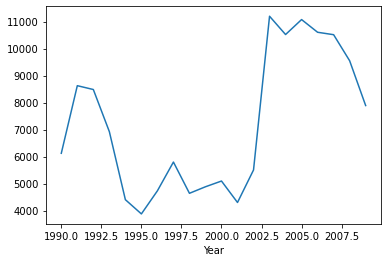

In [195]:
#Total number of flights per year 
small_data_csv.groupby('Year')['Flights'].sum().plot()

### Data Analysis 

Text(0.5, 1.0, 'Log-distribution of the total passengers that boarded and total flights that took off (Small data)')

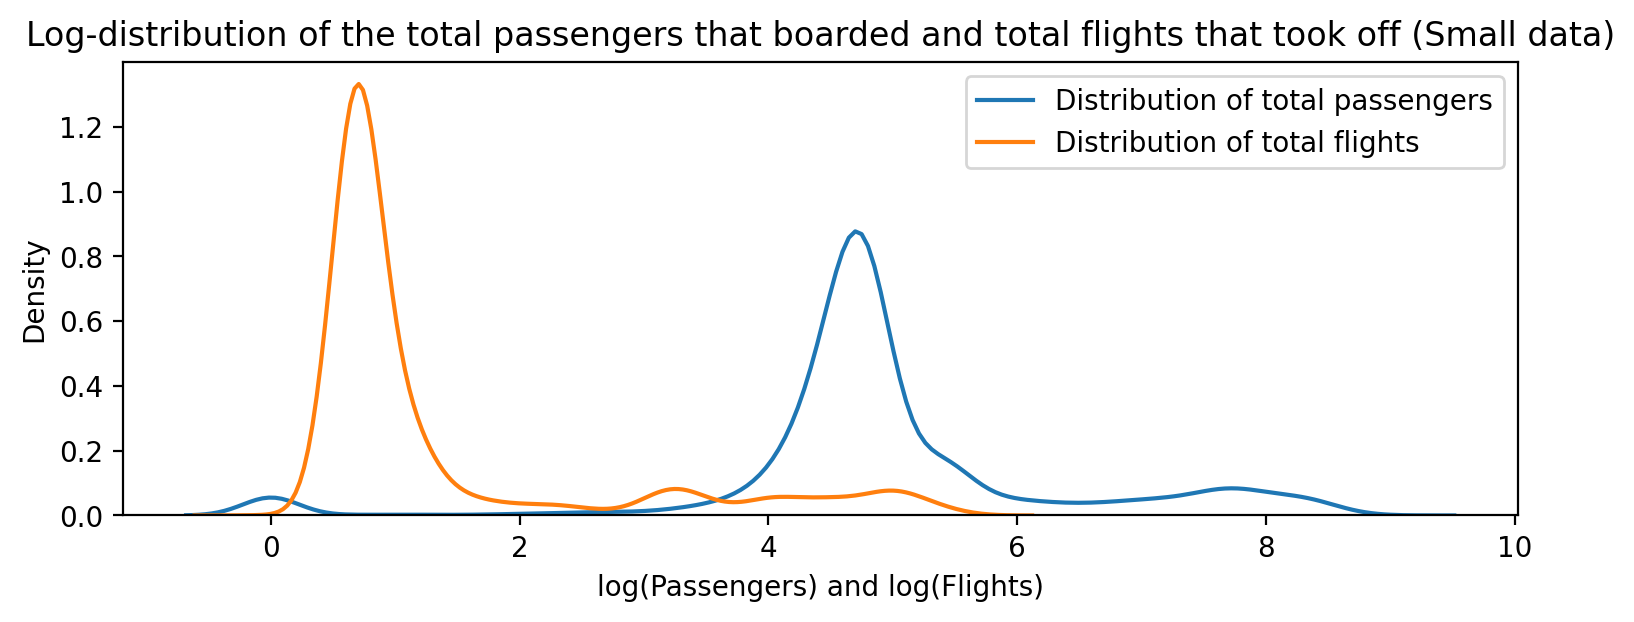

In [196]:
import matplotlib.pyplot as plt
import seaborn as sns 

plt.figure(figsize=(9,3),dpi=200)
sns.kdeplot(np.log1p(small_data_csv['Passengers']))
sns.kdeplot(np.log1p(small_data_csv['Flights']))
plt.legend(['Distribution of total passengers','Distribution of total flights'])
plt.xlabel("log(Passengers) and log(Flights)")
plt.title("Log-distribution of the total passengers that boarded and total flights that took off (Small data)")

Text(0.5, 1.0, 'Log-distribution of the total passengers that boarded and total flights that took off (Medium data)')

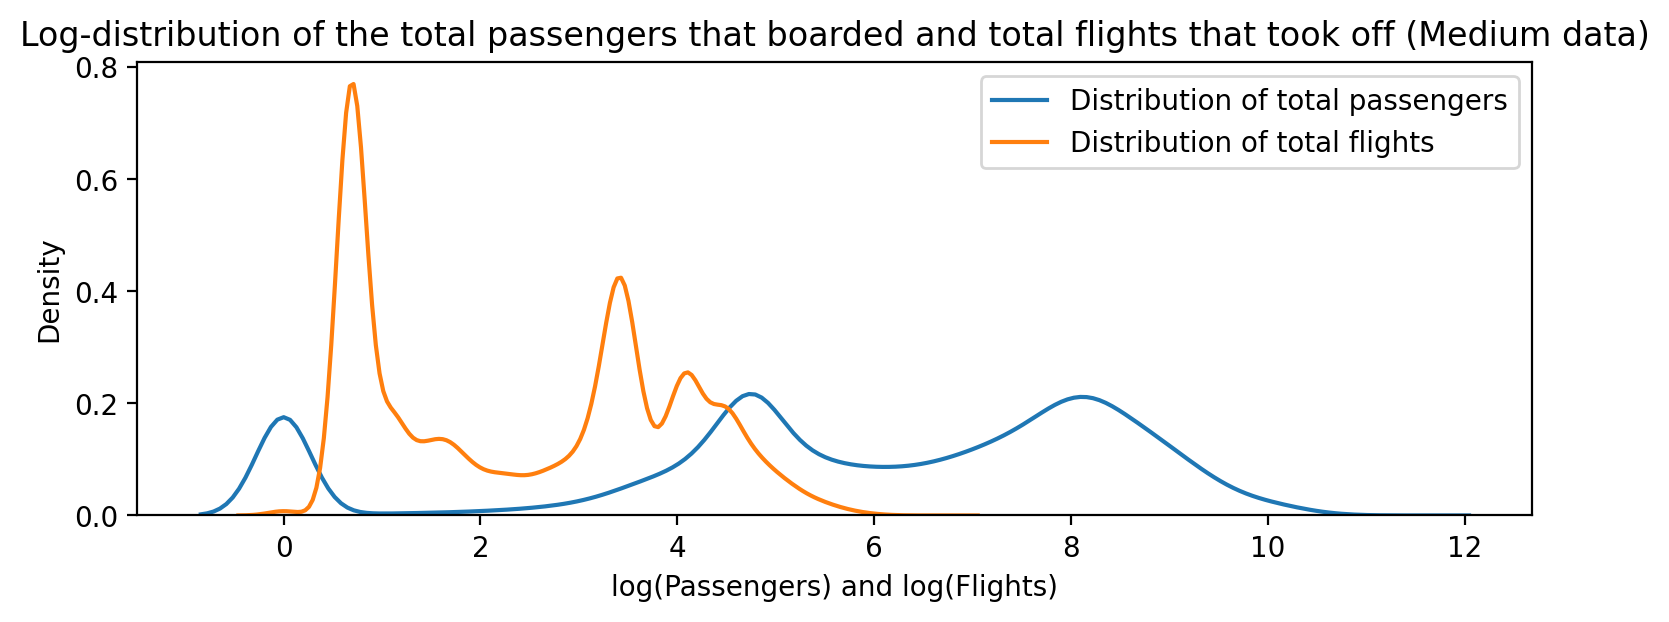

In [197]:
plt.figure(figsize=(9,3),dpi=200)
sns.kdeplot(np.log1p(medium_data_csv['Passengers']))
sns.kdeplot(np.log1p(medium_data_csv['Flights']))
plt.legend(['Distribution of total passengers','Distribution of total flights'])
plt.xlabel("log(Passengers) and log(Flights)")
plt.title("Log-distribution of the total passengers that boarded and total flights that took off (Medium data)")

The above graph shows something interesting: **The number of passengers that boarded the flights was lower in density but higher in frequency, which means that overall, there were more passengers who boarded the flights across all the flights that took off**. This itself is shown by the distance between the two distributions. 

Notice how the peak of the total flights distribution is higher than that of total passengers, implying that the total number of flights that took off was lower in frequency but a higher density overall. Since there is a higher chance of observing more passengers with a less frequency than to more flights with more frequency, the peaks of the two distributions and their distances suggest that the total number of flights that took off did not carry all the passengers with 100% capacity as if that was the case, then the peaks of the distribution should be similar.